In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import math
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from ipywidgets import interact, IntSlider
from IPython.display import display

from lmfit import Model
# import lmfit as lm

In [2]:
"""Defining the Hamiltonian XY model"""

def Hamiltonian2D(J, L):
    Hamiltonian2D = 0.
    n = np.shape(L)[0]
    for x in range (np.shape(L)[0]):
        for y in range (np.shape(L)[0]):
            Hamiltonian2D -= J * ((np.cos(L[x, y] - L[x, (y+1)%n])) + (np.cos(L[x, y] - L[x, (y-1)%n])) 
                                  + (np.cos(L[x, y] - L[(x+1)%n, y])) + (np.cos(L[x, y] - L[(x-1)%n, y])))
    
    
    return Hamiltonian2D/2


In [3]:
"""Defining the artifical Hamiltonian XY model"""

def Hamiltonian2D_art(J, L, P, beta):
    n = np.shape(L)[0]
    Hamiltonian2D_art = sum(sum(P**2))/2 + beta*Hamiltonian2D(J, L)
    return Hamiltonian2D_art

# print(Hamiltonian2D_art(1, L, 1, 1 ))

In [4]:
"""Defining the equations of motion"""

def P_dot_i_2D(J, L):
    n = np.shape(L)[0]
    P_dot_i_2D = np.zeros((n,n))

    for x in range (np.shape(L)[0]):
        for y in range (np.shape(L)[0]):
            P_dot_i_2D[x,y] -= J * ((np.sin(L[x, y] - L[x, (y+1)%n])) + (np.sin(L[x, y] - L[x, (y-1)%n])) 
                                    + (np.sin(L[x, y] - L[(x+1)%n, y])) + (np.sin(L[x, y] - L[(x-1)%n, y])))
    return P_dot_i_2D*beta*J


In [5]:
"""Leapfrog integrator"""

def leapfrog_2D(N_md, p_0,J, L): 
    epsilon = 1/N_md
    p = np.copy(p_0)
    L_new = np.copy(L)
    L_new += p*epsilon/2

    for i in range(N_md-1):
        p += P_dot_i_2D(J, L_new)*epsilon
        L_new += p*epsilon

    
    p +=  P_dot_i_2D(J, L_new)*epsilon
    L_new -= p*epsilon/2
    L_new = abs(L_new%(2*np.pi))
    return p, L_new



In [6]:
"""Now we code the HMC algorithm and get a markove chain (List containing spins) out of it"""

def markov_chain(L_i,N_cfg,N_md,beta,J):
    
    M_arr=[]
    E_arr=[]
    E2_arr=[]
    M2_arr=[]
    spin_list = []
    # L_i_save = L_i

    # bin_length
    count=0
    for k in range(n_therm):
          
        p_hmc = np.random.normal(size=(N,N))
        new = leapfrog_2D(N_md, p_hmc,J, L_i) # Integrating leapfrog algorithm
        prob = np.exp(Hamiltonian2D_art(J,L_i,p_hmc,beta)-Hamiltonian2D_art(J,new[1],new[0],beta))
        if prob > np.random.uniform(0,1):   # Accept/reject
            L_i=new[1] 
                
        
    # L_i = L_i_save
    for i in range(N_cfg):
        m = 0.0
        E = 0.0
        m2=0.
        e2=0.
        for k in range(bin_length):
            
            p_hmc = np.random.normal(size=(N,N))
            new = leapfrog_2D(N_md, p_hmc,J, L_i) # Integrating leapfrog algorithm
            E_new=Hamiltonian2D_art(J,L_i,p_hmc,beta)
            E_old=Hamiltonian2D_art(J,new[1],new[0],beta)
            prob = np.exp(E_old-E_new)
#  Given probability distribution function defined above
            if prob > np.random.uniform(0,1):
                # print("selected")
                Mag=np.sqrt(np.sum(np.cos(new[1]))**2+np.sum(np.sin(new[1]))**2)/N**2
                En=Hamiltonian2D(J,new[1])/N**2
                count+=1
                m2+=Mag**2
                e2+=En**2
                m += Mag
                E += En

        
                L_i = new[1]
                spin_list.append(L_i)

            else:
                Mag=np.sqrt(np.sum(np.cos(L_i))**2+np.sum(np.sin(L_i))**2)/N**2
                En=Hamiltonian2D(J,L_i)/N**2
                m2+=Mag**2
                e2+=En**2
                m += Mag
                E += En
            
        M_arr.append(m / bin_length)
        E_arr.append(E / bin_length)
        M2_arr.append(m2 / bin_length)
        E2_arr.append(e2 / bin_length)

                
    print("Acceptance rate", count / (N_cfg*bin_length))
    return M_arr,E_arr, M2_arr, E2_arr, spin_list



In [7]:
"""To virtually observe the behaviour of spin lattice over some specific 
computation steps the following function can be used"""


def plotting_spins_range(vectors_list, range_initial, range_final, steps, N):

    temp_vectors_list = vectors_list[range_initial:range_final:steps]

    @interact(index=IntSlider(min=0, max=len(temp_vectors_list)-1, step=1, value=0))
    def display_graph(index):
        matrix = temp_vectors_list[index]

        fig, ax = plt.subplots()
        x, y = np.meshgrid(np.arange(N), np.arange(N))
        x_components = np.cos(matrix)
        y_components = np.sin(matrix)
        ax.quiver(x, y, x_components, y_components, angles='xy', scale_units='xy', scale=1)
        ax.set_xlim([-1, N])
        ax.set_ylim([-1, N])
        ax.set_aspect('equal')

        plt.show()

    # Display the interact widget
    display(display_graph)




In [8]:
"""The following function calculates the energy, magnatization, susceptibility 
and heat of lattice for each given point of temprature as 1/Temperature"""


def Analysis_func(N,n_therm,bin_length,N_cfg,N_md,J,T_arr,beta_arr,L_i):


    E_means = []
    mag_means = []

    m_std = []
    E_std = []

    sus = []
    sus_std = []

    heat = []
    heat_std = []

    spinlist = []

    for beta in beta_arr:
        mag_,E_,M2_arr, E2_arr, spinlist = markov_chain(L_i,N_cfg,N_md,beta,J)


        k_ = np.mean(np.array(mag_))
        en_ = np.mean(np.array(E_))
        E_means.append(en_)
        mag_means.append(k_)

        m_std.append(np.std(mag_))
        E_std.append(np.std(E_))

        sus.append((np.mean( M2_arr) - np.square(np.mean(mag_)))*beta*N**2)
        sus_std.append(np.std( M2_arr - np.square(mag_)*beta*N**2))

        heat.append((np.mean(E2_arr) - np.square(np.mean(np.array(E_))))*beta**2*N**2)
        heat_std.append(np.std((E2_arr - np.array(E_)**2)*beta**2*N**2))


    return E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std 

In [9]:
"FITTING STARTS HERE"


def Lorentzian(x, amp1, cen1, wid1):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2))

gmodel = Model(Lorentzian)



"""To understand the behavious of the lattice over the given temperature and 
to find the proper fitting to it we define the following function"""

def Fittings(T_arr, N, E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std):
    
    plt.scatter(T_arr[::-1], E_means,label="Energy")
    plt.errorbar(T_arr[::-1], E_means, yerr=E_std, ls = "")
    plt.grid()
    plt.legend()
    plt.xlabel("Temperature (units)")
    plt.ylabel("Energy <E>")
    plt.title(f"Dependence of Energy on Temperature for N = {N}")
    # plt.savefig(f"energy_{N}.png")
    plt.show()

    plt.scatter(T_arr[::-1],mag_means,label="Magnetization")
    plt.errorbar(T_arr[::-1], mag_means, yerr=m_std,ls = "")
    plt.grid()
    plt.legend()
    plt.xlabel("Temperature (units)")
    plt.ylabel("Magnetization <m>")
    plt.title(f"Dependence of Magnetization on Temperature for N = {N}")
    # plt.savefig(f"mag_{N}.png")
    plt.show()

    params = gmodel.make_params(amp1=0.25, cen1=0.6, wid1=0.15)
    result = gmodel.fit(sus, params, x=T_arr[::-1])
    print(result.fit_report())

    beta_arr_cont= np.linspace(0,2.2,100)
    fitted_func= Lorentzian(beta_arr_cont, result.params.valuesdict()['amp1'],
                             result.params.valuesdict()['cen1'],result.params.valuesdict()['wid1'])
    



    plt.scatter(T_arr[::-1],sus,label="Susceptibility")
    plt.errorbar(T_arr[::-1], sus, yerr=np.array(sus_std)/N**2,ls = "")
    plt.plot(beta_arr_cont, fitted_func, '.-', label='Fit Function')
    plt.grid()
    plt.legend()
    plt.xlabel("Temperature (units)")
    plt.ylabel("Susceptibility")
    plt.title(f"Dependence of Susceptibility on Temperature for N = {N}")
    # plt.savefig(f"sus_{N}.png")
    plt.show()

    T_arr_new= T_arr[::-1]
    popt, cov= curve_fit(Lorentzian, T_arr_new[T_arr_new>0.6], np.array(heat)[T_arr_new>0.6])
    print(popt)

    beta_arr_cont= np.linspace(0,2.2,100)
    fitted_func_heat= Lorentzian(beta_arr_cont, popt[0],
                             popt[1],popt[2])
    
    peak_value_heat = np.max(fitted_func_heat)

    plt.scatter(T_arr_new[T_arr_new>0.25],np.array(heat)[T_arr_new>0.25],label="Specific Heat")
    plt.errorbar(T_arr[::-1], heat, yerr=np.array(heat_std)/N**2,ls = "")
    plt.plot(beta_arr_cont, fitted_func_heat, '.-', label='Fit Function')
    plt.ylim(0,peak_value_heat)
    plt.grid()
    plt.legend()
    plt.xlabel("Temperature (units)")
    plt.ylabel("Specific Heat")
    plt.title(f"Dependence of Specific Heat on Temperature for N = {N}")
    # plt.savefig(f"sp_heat_{N}.png")
    plt.show()


In [10]:
"""To study the TRENDS (change in behaviour of lattice with the variations in lattice sizes) 
the following function is used"""

def Trends(N_list,E_means_new,E_std_new,mag_means_new,m_std_new,sus_new,sus_std_new,heat_new,heat_std_new):
    
    legend_labels = [f"N={n}" for n in N_list]
    
    # Plotting graph for Dependence of Energy on Temperature for various N
    for i, Energy_list in enumerate(E_means_new):
        plt.scatter(T_arr[::-1], Energy_list, marker='o', label=legend_labels[i])
        plt.errorbar(T_arr[::-1], Energy_list, yerr=E_std_new[i], ls = "")

    plt.legend(loc='upper right')
    plt.xlabel("Temperature (units)")
    plt.ylabel("Energy <E>")
    plt.title("Dependence of Energy on Temperature for various N")
    # plt.savefig("energy_trend.png")
    plt.grid(True)
    plt.show()

    
    
    # Plotting graph for Dependence of Magnetization on Temperature for various N
    for i, Magnetization_list in enumerate(mag_means_new):
        plt.scatter(T_arr[::-1], Magnetization_list, marker='o', label=legend_labels[i])
        plt.errorbar(T_arr[::-1], Magnetization_list, yerr=m_std_new[i], ls = "")

    plt.legend(loc='upper right')
    plt.xlabel("Temperature (units)")
    plt.ylabel("Magnetization <m>")
    plt.title("Dependence of Magnetization on Temperature for various N")
    # plt.savefig("mag_trend.png")
    plt.grid(True)
    plt.show()
    
    
    
    # Plotting graph for Dependence of Susceptibility on Temperature for various N
    for i, Susceptibility_list in enumerate(sus_new):
        plt.scatter(T_arr[::-1], Susceptibility_list, marker='o', label=legend_labels[i])
        plt.errorbar(T_arr[::-1], Susceptibility_list, yerr=sus_std_new[i], ls = "")

    plt.legend(loc='upper right')
    plt.xlabel("Temperature (units)")
    plt.ylabel("Susceptibility")
    plt.title("Dependence of Susceptibility on Temperature for various N")
    # plt.savefig("sus_trend.png")
    plt.grid(True)
    plt.show()
    
    
    
    # Plotting graph for Dependence of Specific Heat on Temperature for various N
    for i, Specific_Heat_list in enumerate(heat_new):
        plt.scatter(T_arr[::-1], Specific_Heat_list, marker='o', label=legend_labels[i])
        plt.errorbar(T_arr[::-1], Specific_Heat_list, yerr=heat_std_new[i], ls = "")

    plt.legend(loc='upper right')
    # plt.ylim(0,2)
    plt.xlabel("Temperature (units)")
    plt.ylabel("Specific Heat")
    plt.title("Dependence of Specific Heat on Temperature for various N")
    # plt.savefig("sp_heat_trend.png")
    plt.grid(True)
    plt.show()
    





[[1.04355047 0.49845308 2.23568141 4.61153921 4.25194839]
 [1.49958777 4.43779749 3.00905385 4.74809753 0.50638579]
 [3.87708011 2.26059967 0.79628004 3.02119328 4.48474524]
 [6.04706114 3.80016156 5.51074417 0.67258936 4.22911655]
 [2.0731262  0.54321934 0.74383585 5.90306621 4.26826924]]
2


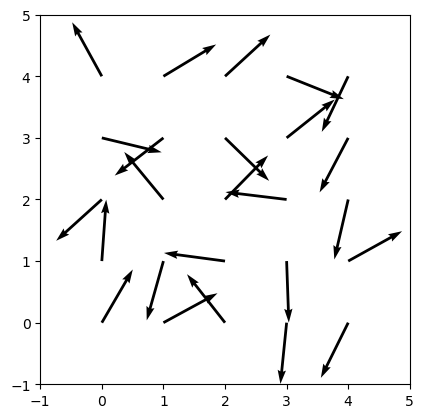

In [11]:
"""Just to visualize a apin lattice"""
N = 5
L =  np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)]) # ask
p_0 = np.random.normal(size=(N,N))
J = 1
beta = 1.0

print(L)

fig, ax = plt.subplots()
x, y = np.meshgrid(np.arange(5), np.arange(5))
x_components = np.cos(L)
y_components = np.sin(L)
ax.quiver(x, y, x_components, y_components, angles='xy', scale_units='xy', scale=1)
ax.set_xlim([-1, 5])
ax.set_ylim([-1, 5])
ax.set_aspect('equal')


# Defining some variables

print(np.ndim(L))

ini= 11.128313939267894
final= 11.153803903527159


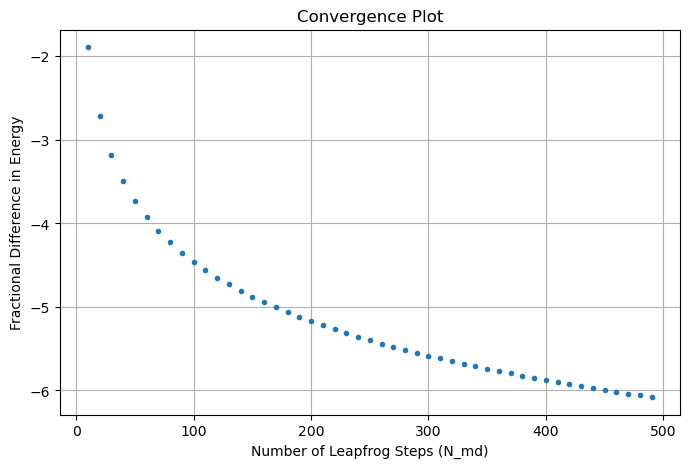

<Figure size 640x480 with 0 Axes>

In [12]:
"""To see the convergence of leapfrog integrator"""


diff = []
range_1 =[i for i in range(10,500,10)]
p_0 = np.random.normal(size=(N,N))
for N_md in range_1:
   
    arr = leapfrog_2D(N_md, p_0, J,L)
    p_f = arr[0]          # We need final values of p_f and phi_f to calculate H_f
    Lat_ev = arr[1]
    H_f = Hamiltonian2D_art(J, Lat_ev, p_f, beta)
    H_0 = Hamiltonian2D_art(J, L, p_0, beta)
# dimension of L is 2 and p_0 
# The following is the quantity we want on y-axis
    diff.append(abs((H_f-H_0)/H_0)) 
    
# print(p_0)
# print(L)
# print(phi_f)

print("ini=",H_0)
print("final=",H_f)


plt.figure(figsize=(8,5))
plt.xlabel('Number of Leapfrog Steps (N_md)')
plt.ylabel('Fractional Difference in Energy')
plt.title('Convergence Plot')
plt.grid()
plt.plot(range_1, np.log(diff),'.')
# plt.yscale("log")
plt.show()
# plt.savefig("leap.pgf")
# plt.savefig("leap.png")

Acceptance rate 0.9107
M_avg = 0.7896867783532423, E_avg = -1.386197769901214


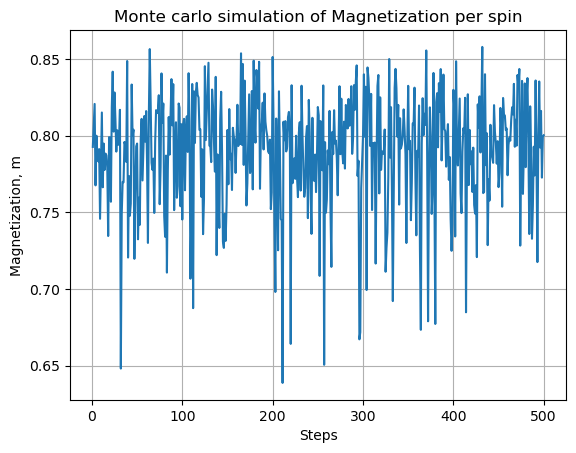

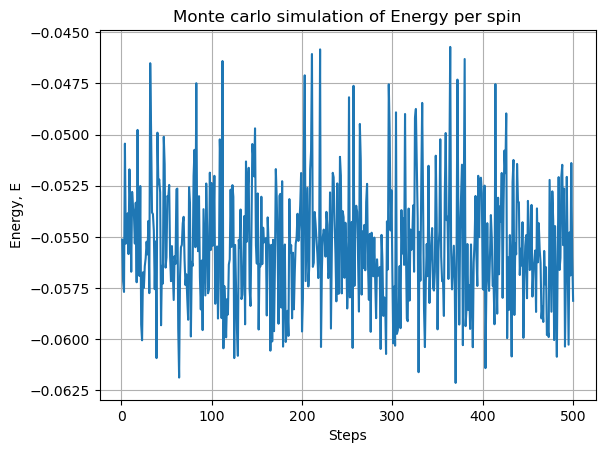

In [13]:
"""To see the general trend of Monte Carlo simulation for spin lattice"""

n_therm = 1000
bin_length = 20
L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
N_cfg = 500
N_md = 30
J = 1.0
beta = 1.0
M_arr,E_arr, M2_arr, E2_arr, spinlist = markov_chain(L_i,N_cfg,N_md,beta,J)
M_avg = np.mean(M_arr)
E_avg = np.mean(E_arr)
print(f"M_avg = {M_avg}, E_avg = {E_avg}")


plt.plot(np.arange(1,N_cfg+1,1),M_arr)
plt.grid()
plt.xlabel("Steps")
plt.ylabel("Magnetization, m")
plt.title("Monte carlo simulation of Magnetization per spin")
plt.show()
# plt.savefig("mcmc_mag.png")
# plt.savefig("mcmc_mag.pgf")

plt.plot(np.arange(1,N_cfg+1,1),np.array(E_arr)/N**2)
plt.grid()
plt.xlabel("Steps")
plt.ylabel("Energy, E")
plt.title("Monte carlo simulation of Energy per spin")
plt.show()
# plt.savefig("mcmc_energy.png")
# plt.savefig("mcmc_mag.pgf")

In [14]:
"""To graphically observe the behaviour of lattice on big scale, hence variations in spin lattice over given computation steps"""
N = 50
n_therm = 10
N_cfg = 5

L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)])
bin_length = 20
N_md = 30
J = 1.0
beta = 1.0

M_arr,E_arr, M2_arr, E2_arr, spinlist = markov_chain(L_i,N_cfg,N_md,beta,J)
M_avg = np.mean(M_arr)
E_avg = np.mean(E_arr)
print(f"M_avg = {M_avg}, E_avg = {E_avg}")

Acceptance rate 0.96
M_avg = 0.06296919755887997, E_avg = -1.2133081278600137


In [15]:
"""Now we plot the selected range of graphs from the data calculated above for observation"""
# plotting_spins_range(vectors_list, range_initial, range_final, steps, N)
plotting_spins_range(spinlist, 0, 50, 1, N)

print(f"\n ***Use slider to scroll between slides*** \n \n Average magnatization = {M_avg} \n Average energy = {E_avg}")

interactive(children=(IntSlider(value=0, description='index', max=49), Output()), _dom_classes=('widget-intera…

<function __main__.plotting_spins_range.<locals>.display_graph(index)>


 ***Use slider to scroll between slides*** 
 
 Average magnatization = 0.06296919755887997 
 Average energy = -1.2133081278600137


# Fitting

Acceptance rate 0.3415
Acceptance rate 0.37466666666666665
Acceptance rate 0.43616666666666665
Acceptance rate 0.5121666666666667
Acceptance rate 0.6148333333333333
Acceptance rate 0.8358333333333333
Acceptance rate 0.7921666666666667
Acceptance rate 0.29683333333333334
Acceptance rate 0.034833333333333334
Acceptance rate 0.005166666666666667
Acceptance rate 0.004
Fitting for N = 5


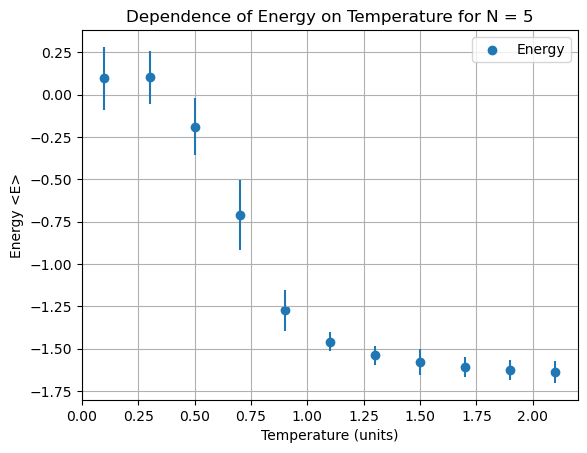

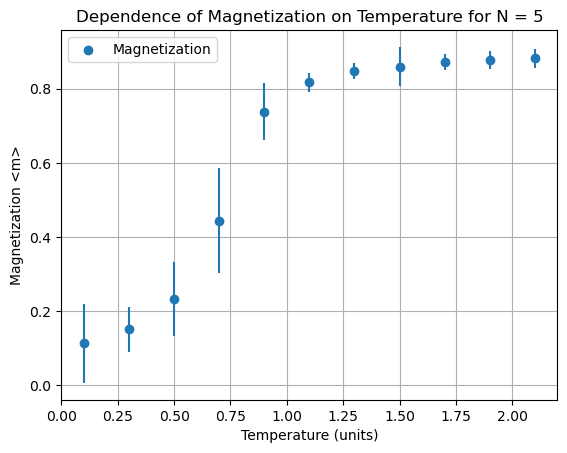

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2497
    # data points      = 11
    # variables        = 3
    chi-square         = 1.05792485
    reduced chi-square = 0.13224061
    Akaike info crit   = -19.7574457
    Bayesian info crit = -18.5637599
    R-squared          = 0.85557617
[[Variables]]
    amp1:  92158.0431 +/- 1.5547e+10 (16870012.94%) (init = 0.25)
    cen1: -0.14616473 +/- 0.93221418 (637.78%) (init = 0.6)
    wid1:  0.00136794 +/- 115.909805 (8473310.54%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -1.000
    C(amp1, cen1) = -0.995
    C(cen1, wid1) = 0.995


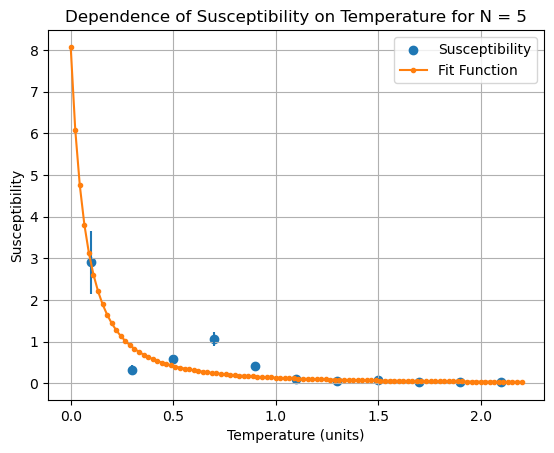

[3.25924092 0.72486328 0.17349147]


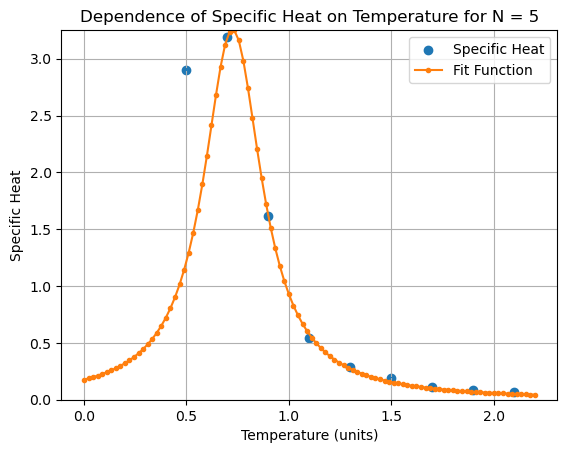

Acceptance rate 0.13583333333333333
Acceptance rate 0.14683333333333334
Acceptance rate 0.19433333333333333
Acceptance rate 0.2875
Acceptance rate 0.42916666666666664
Acceptance rate 0.7591666666666667
Acceptance rate 0.673
Acceptance rate 0.13816666666666666
Acceptance rate 0.014166666666666666
Acceptance rate 0.004333333333333333
Acceptance rate 0.0045
Fitting for N = 8


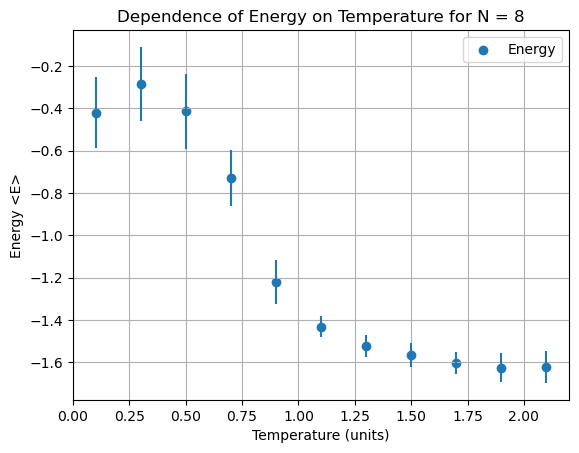

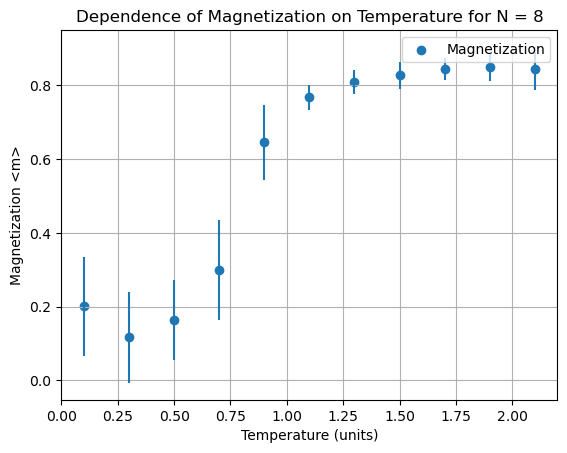

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4637
    # data points      = 11
    # variables        = 3
    chi-square         = 1.39653201
    reduced chi-square = 0.17456650
    Akaike info crit   = -16.7029357
    Bayesian info crit = -15.5092499
    R-squared          = 0.98767498
[[Variables]]
    amp1:  371888.147 +/- 1.7390e+10 (4676255.87%) (init = 0.25)
    cen1: -0.15382382 +/- 0.26556052 (172.64%) (init = 0.6)
    wid1:  0.00140861 +/- 33.0148161 (2343779.55%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -1.000
    C(amp1, cen1) = -0.995
    C(cen1, wid1) = 0.995


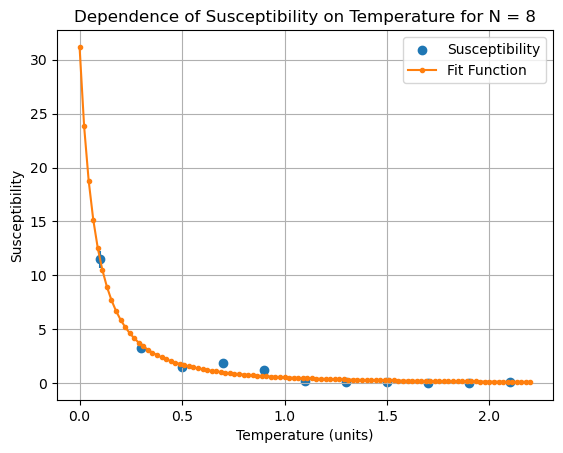

[2.89418903 0.7631912  0.18505924]


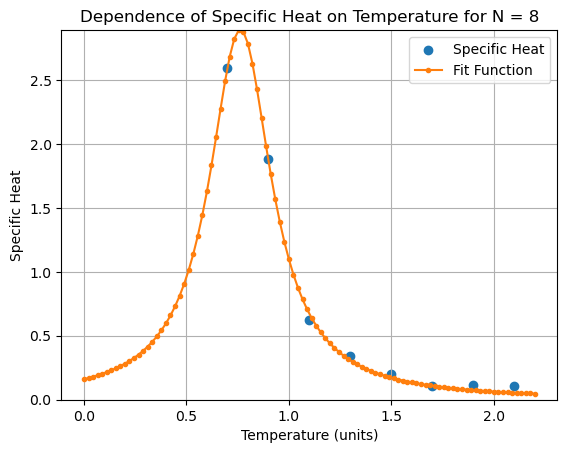

Acceptance rate 0.0485
Acceptance rate 0.09566666666666666
Acceptance rate 0.13133333333333333
Acceptance rate 0.175
Acceptance rate 0.3606666666666667
Acceptance rate 0.6966666666666667
Acceptance rate 0.6046666666666667
Acceptance rate 0.05366666666666667
Acceptance rate 0.0065
Acceptance rate 0.004666666666666667
Acceptance rate 0.005166666666666667
Fitting for N = 10


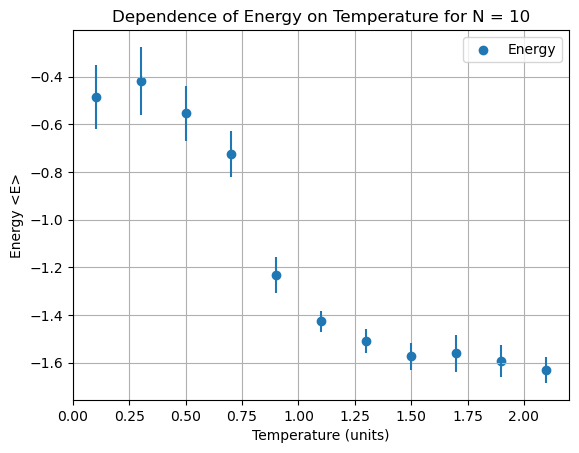

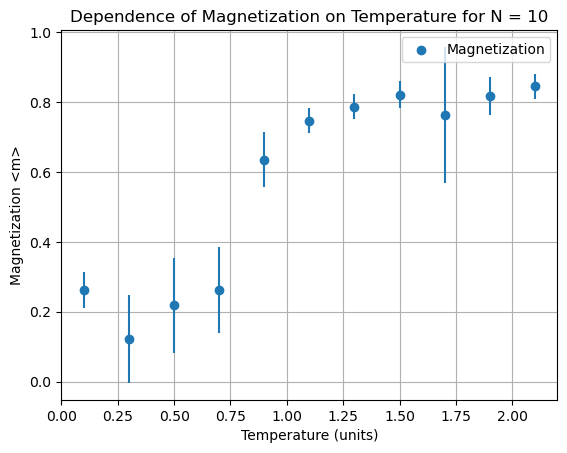

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 11
    # variables        = 3
    chi-square         = 4.56234624
    reduced chi-square = 0.57029328
    Akaike info crit   = -3.68064081
    Bayesian info crit = -2.48695499
    R-squared          = 0.85136062
[[Variables]]
    amp1:  5.24352222 +/- 0.74347047 (14.18%) (init = 0.25)
    cen1:  0.34291976 +/- 0.04184584 (12.20%) (init = 0.6)
    wid1:  0.27904257 +/- 0.06563315 (23.52%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.707
    C(cen1, wid1) = -0.266
    C(amp1, cen1) = 0.153


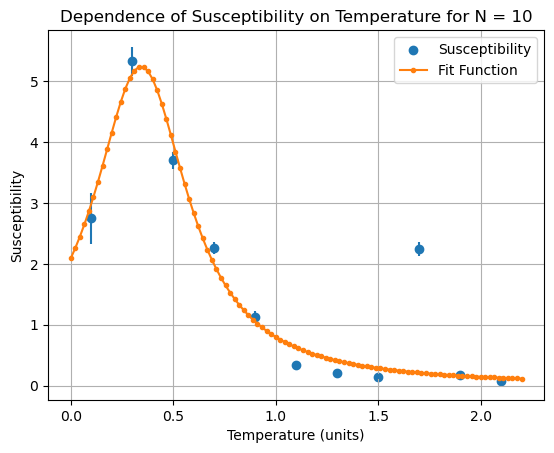

[2.26284594 0.78112607 0.2153682 ]


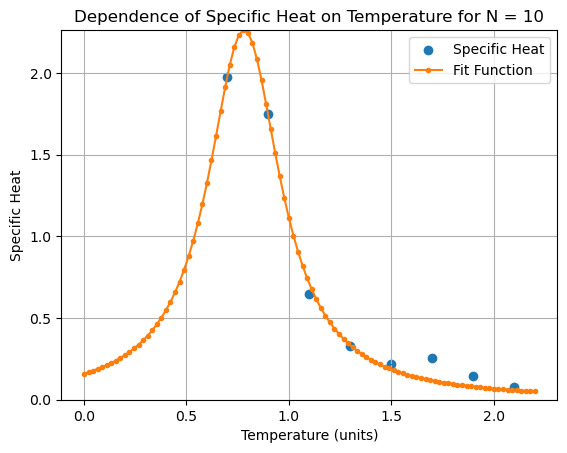

Acceptance rate 0.0305
Acceptance rate 0.036166666666666666
Acceptance rate 0.07933333333333334
Acceptance rate 0.14016666666666666
Acceptance rate 0.2735
Acceptance rate 0.6413333333333333
Acceptance rate 0.567
Acceptance rate 0.0305
Acceptance rate 0.005333333333333333
Acceptance rate 0.0033333333333333335
Acceptance rate 0.0045
Fitting for N = 12


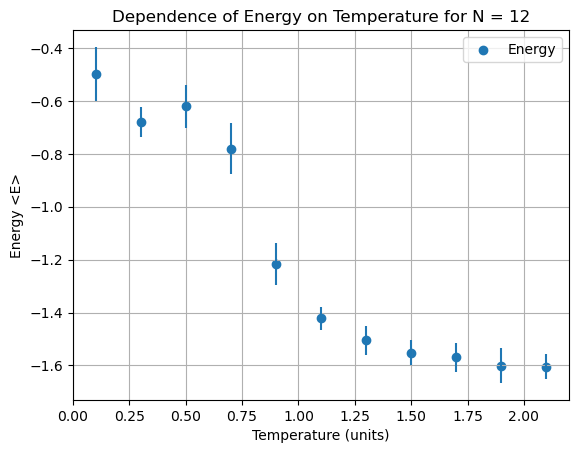

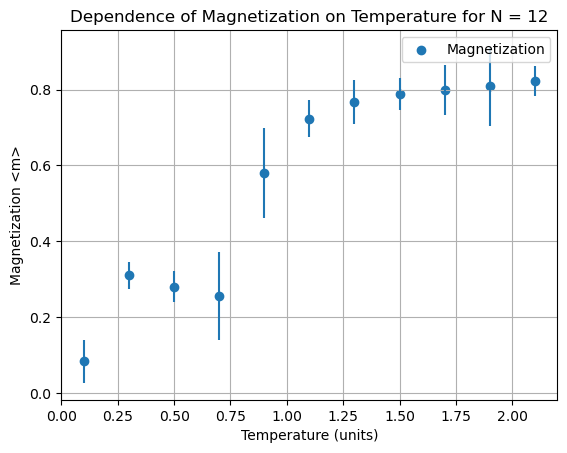

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1803
    # data points      = 11
    # variables        = 3
    chi-square         = 11.7594333
    reduced chi-square = 1.46992917
    Akaike info crit   = 6.73436532
    Bayesian info crit = 7.92805114
    R-squared          = 0.46980342
[[Variables]]
    amp1:  106373.281 +/- 1.7819e+10 (16751201.28%) (init = 0.25)
    cen1: -0.64723922 +/- 3.55196721 (548.79%) (init = 0.6)
    wid1:  0.00456063 +/- 384.359356 (8427761.04%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -1.000
    C(amp1, cen1) = -0.992
    C(cen1, wid1) = 0.992


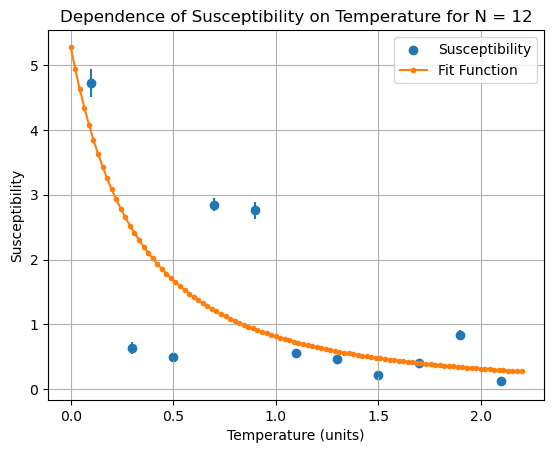

[2.97693659 0.75511951 0.20175857]


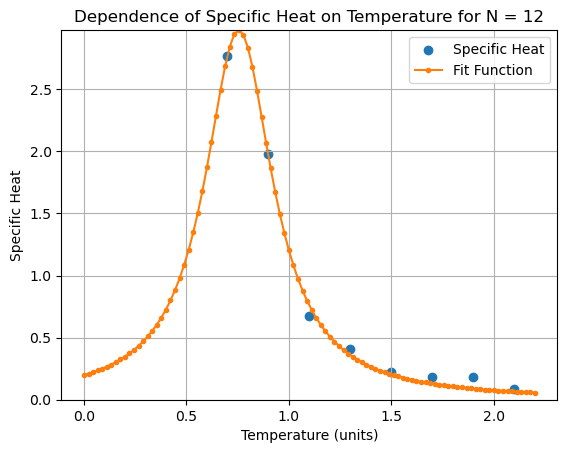

Acceptance rate 0.018
Acceptance rate 0.024166666666666666
Acceptance rate 0.03816666666666667
Acceptance rate 0.0695
Acceptance rate 0.16
Acceptance rate 0.5735
Acceptance rate 0.47583333333333333
Acceptance rate 0.0255
Acceptance rate 0.006666666666666667
Acceptance rate 0.0035


C:\Users\arsal\AppData\Local\Temp\ipykernel_24804\4092246456.py:18: RuntimeWarning: overflow encountered in exp
  prob = np.exp(Hamiltonian2D_art(J,L_i,p_hmc,beta)-Hamiltonian2D_art(J,new[1],new[0],beta))


Acceptance rate 0.0035
Fitting for N = 15


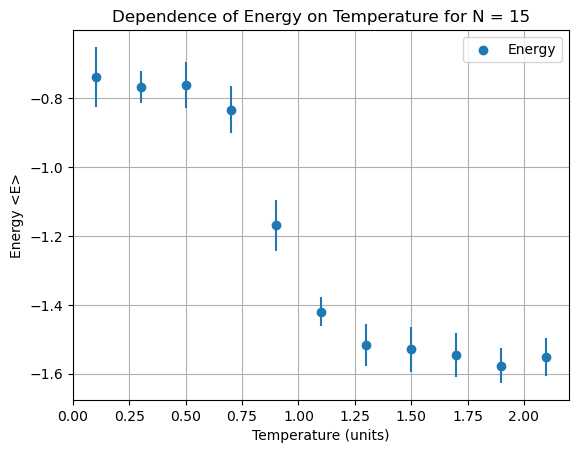

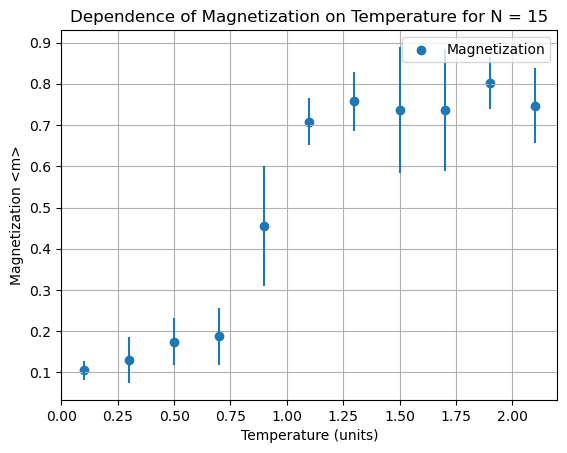

[[Model]]
    Model(Lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 11
    # variables        = 3
    chi-square         = 21.1498363
    reduced chi-square = 2.64372954
    Akaike info crit   = 13.1911058
    Bayesian info crit = 14.3847917
    R-squared          = 0.14740321
[[Variables]]
    amp1:  2.81452365 +/- 0.94432109 (33.55%) (init = 0.25)
    cen1:  0.97246590 +/- 0.31168320 (32.05%) (init = 0.6)
    wid1:  0.91178857 +/- 0.63118042 (69.22%) (init = 0.15)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp1, wid1) = -0.723
    C(cen1, wid1) = -0.121


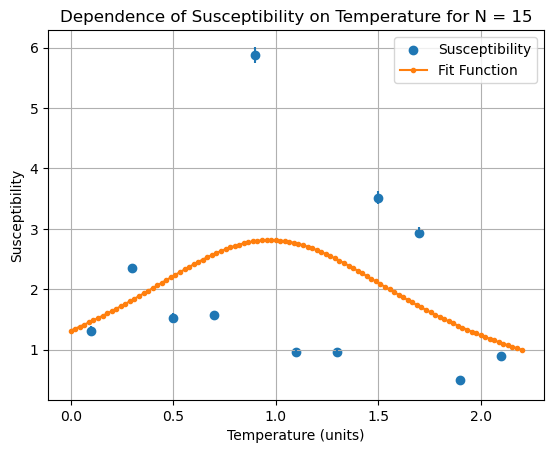

[2.5717228  0.80058855 0.24434455]


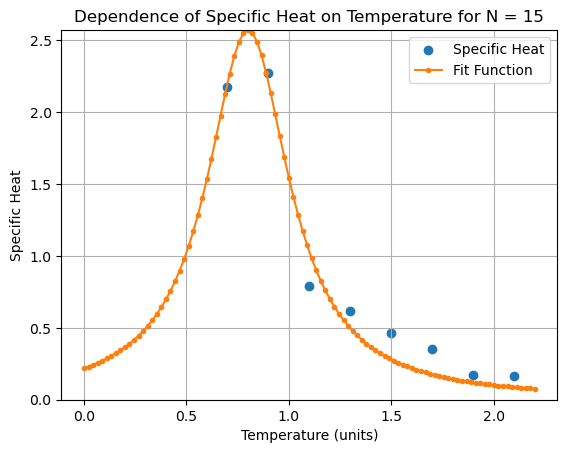

In [16]:
"""Now we will calculate the fittings for spin lattices of different sizes"""
# Analysis_func(N,n_therm,bin_length,N_cfg,N_md,J,T_arr,beta_arr)
# Fittings(T_arr, N, E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std)

N_list = [5,8,10,12,15]

# n_therm = 10 # for test run
# N_cfg = 5 # for test run

n_therm = 1000
N_cfg = 200

bin_length = 30
N_md = 50


J = 1.0
T_arr = np.arange(0.1, 2.20, 0.20)
beta_arr=np.sort(1/T_arr)

E_means_new = []
E_std_new = []
mag_means_new = []
m_std_new = []
sus_new = []
sus_std_new = []
heat_new = []
heat_std_new = []

for N in N_list:
    L_i = np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)]) #generating a random lattice of the size N

    E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std  = Analysis_func(N,n_therm,bin_length,N_cfg,N_md,J,T_arr,beta_arr,L_i)

    E_means_new.append(E_means)
    E_std_new.append(E_std)
    mag_means_new.append(mag_means)
    m_std_new.append(m_std)
    sus_new.append(sus)
    sus_std_new.append(sus_std)
    heat_new.append(heat)
    heat_std_new.append(heat_std)
    
    print(f"Fitting for N = {N}")
    Fittings(T_arr, N, E_means , E_std , mag_means , m_std , sus ,sus_std ,heat ,heat_std)


Considering the peak to be somewhere around 0.83, T = 1/0.83 = 1.204 in natural units where k_B = 1

But here the graph is not completely correct as we see that there is a secondary peak at the same y-axis level.

# TRENDS

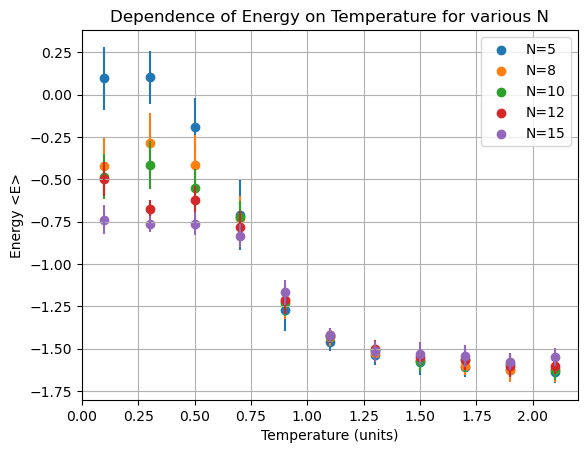

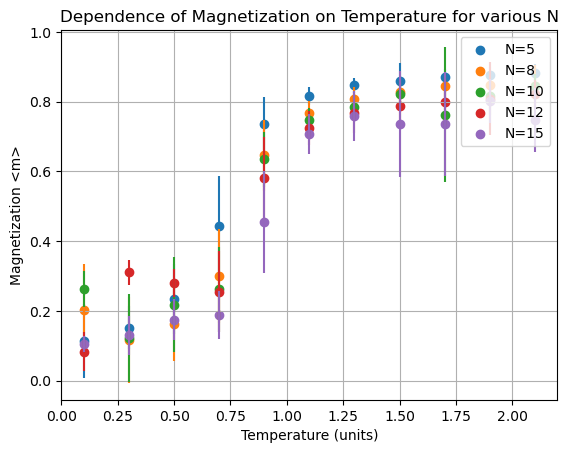

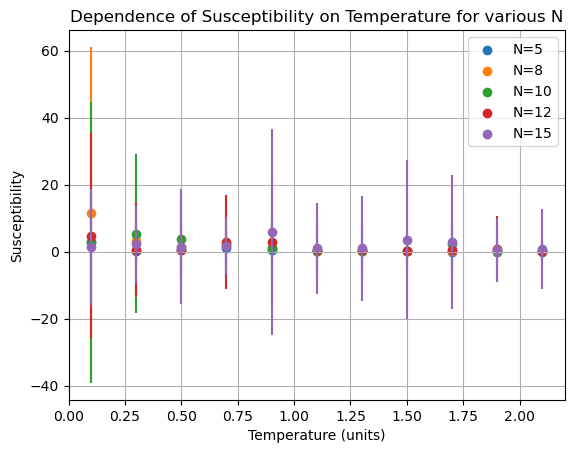

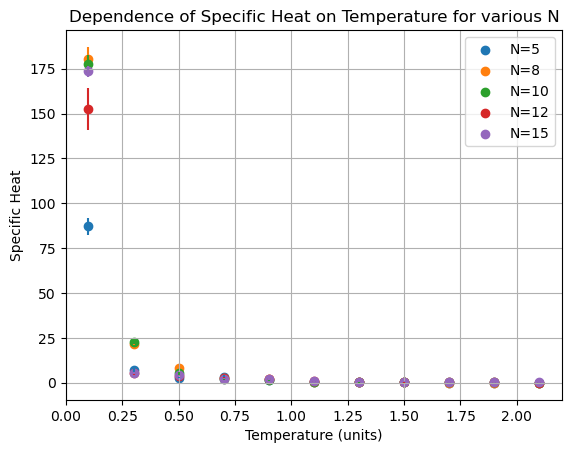

In [17]:
Trends(N_list,E_means_new,E_std_new,mag_means_new,m_std_new,sus_new,sus_std_new,heat_new,heat_std_new)